# AQMS Modeling

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import os
os.environ["KERAS_BACKEND"] = "torch"
import keras

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")
    
torch.mps.set_per_process_memory_fraction(0.0)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

tensor([1.], device='mps:0')


## Load Dataset

In [31]:
data = pd.read_csv("dataset/Indeks Standar Pencemar Udara di Provinsi DKI Jakarta 2021.csv")
data['tanggal'] = pd.to_datetime(data['tanggal'])
data.set_index('tanggal', inplace=True)
data = data[['co']]

data

,co
tanggal,
2021-01-01,29
2021-01-02,38
2021-01-03,25
2021-01-04,24
2021-01-05,24
...,...
2021-12-27,23
2021-12-28,16
2021-12-29,15


In [32]:
data.isnull().sum()

co    0
dtype: int64

## Time Plot

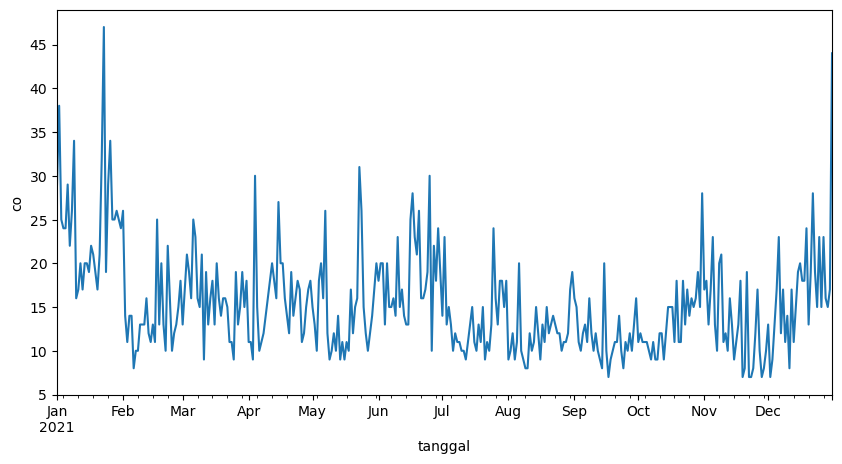

In [33]:
data["co"].plot(figsize = (10,5))
plt.ylabel("co")
plt.show()

## Decomposition

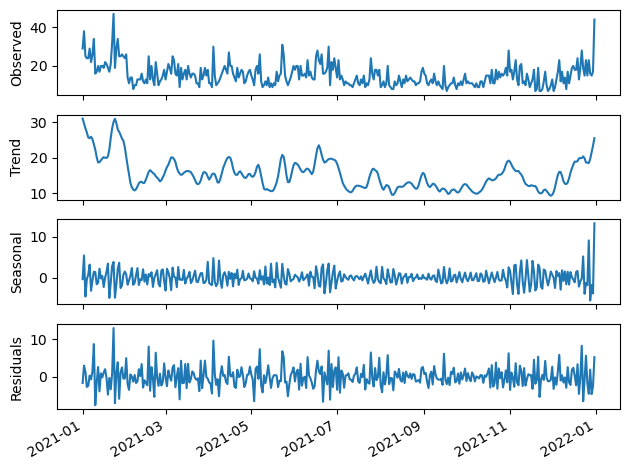

In [34]:
advanced_decomposition = STL(data["co"], period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## Modeling 1

In [40]:
baseline = data[['co']].copy(deep=True)
baseline['prev_co'] = baseline['co'].shift(1)
baseline.drop(index=baseline.index[0], inplace=True)
baseline['difference'] = baseline['co'] - baseline['prev_co']
baseline['square_error'] = baseline['difference'] ** 2
# baseline.head(2)

square_error = baseline['square_error'].mean()
print(f'Square Error of the Naive Approach is {square_error:.3f}')

Square Error of the Naive Approach is 33.382


In [45]:
input_data = data

targets = data['co'].values
T = 30                    # jumlah timestep yang digunakan untuk prediksi
D = input_data.shape[1]   # jumlah dimensi input
N = len(input_data) - T   # jumlah data yang dapat menjadi output prediksi

In [50]:
# menentukan jumlah train_size
train_size = int(len(input_data) * 0.70)

# normalisasi input
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
    X_train[t, :, :] = input_data[t:t+T]
    y_train[t] = (targets[t+T])

X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
    t = i + train_size
    X_test[i, :, :] = input_data[t:t+T]
    y_test[i] = (targets[t+T])

# ubah tipe data menjadi tensor
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [52]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()
        self.M = hidden_dim
        self.L = layer_dim

        self.rnn = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True)
    
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
    
        # hidden state dan cell state
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])
        return out

In [53]:
model = LSTM(D, 512, 2, 1)
model.to(device)

LSTM(
  (rnn): LSTM(1, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [54]:
def train(model, learning_rate, X_train, y_train, X_test, y_test, epochs=200):

    # loss dan optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for epoch in range(epochs):
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # backpropagation
        loss.backward()
        optimizer.step()

        # train loss
        train_losses[epoch] = loss.item()

        # test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()

        if (epoch + 1) % 50 == 0:
            print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')

    return train_losses, test_losses

In [55]:
# pindahkan ke GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, test_losses = train(model, 0.01, X_train, y_train, X_test, y_test, epochs=750)

At epoch 50 of 750, Train Loss: 19.392, Test Loss: 30.559
At epoch 100 of 750, Train Loss: 17.069, Test Loss: 28.975
At epoch 150 of 750, Train Loss: 16.831, Test Loss: 28.894
At epoch 200 of 750, Train Loss: 16.688, Test Loss: 29.029
At epoch 250 of 750, Train Loss: 16.190, Test Loss: 30.884
At epoch 300 of 750, Train Loss: 16.319, Test Loss: 31.405
At epoch 350 of 750, Train Loss: 16.808, Test Loss: 29.010
At epoch 400 of 750, Train Loss: 16.427, Test Loss: 29.196
At epoch 450 of 750, Train Loss: 16.132, Test Loss: 30.727
At epoch 500 of 750, Train Loss: 15.585, Test Loss: 32.270
At epoch 550 of 750, Train Loss: 15.768, Test Loss: 30.730
At epoch 600 of 750, Train Loss: 14.771, Test Loss: 32.658
At epoch 650 of 750, Train Loss: 16.255, Test Loss: 28.932
At epoch 700 of 750, Train Loss: 14.859, Test Loss: 28.310
At epoch 750 of 750, Train Loss: 12.462, Test Loss: 32.191


### Plot Training Result

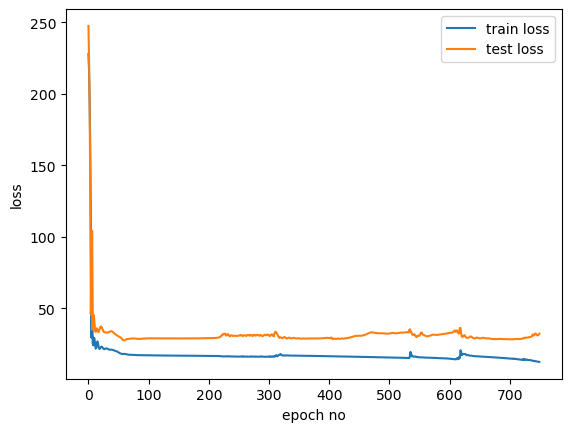

In [56]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

### Plot Prediction Performance

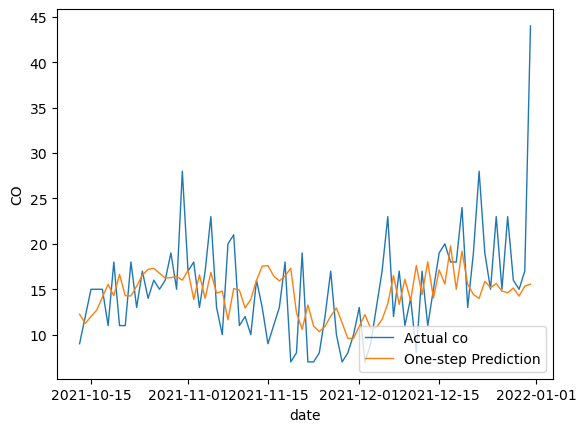

In [60]:
# cek predikti untuk 1 step atau 1 hari
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
    input_ = X_test[i].reshape(1, T, D)
    p = model(input_)[0,0].item()

    test_predictions.append(p)

plot_len = len(test_predictions)
plot_df = data[['co']].copy(deep=True)

plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions
# plot_df.set_index('dt', inplace=True)

plt.plot(plot_df['co'], label='Actual co', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('CO')
plt.legend(loc='lower right')
plt.show()

In [58]:
LTSM_error = pd.DataFrame(test_target, columns = ['targets'])
LTSM_error['predictions'] =test_predictions
LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
LTSM_error['error_square'] = LTSM_error['error'] ** 2
err = LTSM_error['error_square'].mean()
print(f'Mean square error is: {err:.3f}')

Mean square error is: 32.191


### Plot Error Distribution

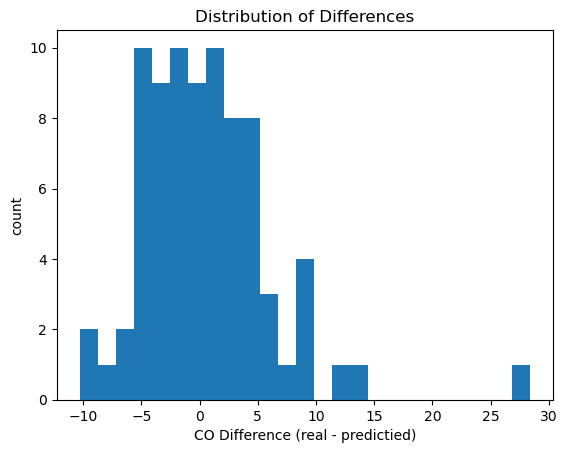

In [61]:
plt.hist(LTSM_error['error'], bins=25)
plt.xlabel('CO Difference (real - predictied)')
plt.ylabel('count')
plt.title('Distribution of Differences')
plt.show()